# Testing RDD on Generated Data

### Libraries

In [4]:
import arviz as az  # Analysis of Bayesian Models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm  # Bayesian Statistical Models
import random

### Generating Random Data Set

In [ ]:
# Fixing Random
RANDOM_SEED = 123
# Different Random Generators
rng = np.random.default_rng(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Fixing the plot style
az.style.use("arviz-darkgrid")
%config InlineBackend.figure=format = 'retina' # <- high DPI, shrper plots

In [29]:
# --- Defining parameters ---
threshold = 15
treatment_effect = 0.7
N = 1000
sd = 0.3

# --- Simulating ---
possible_ages = np.arange(10, 18, 0.5)
ages = rng.choice(possible_ages, size=N)
df = (
    pd.DataFrame({"x": ages})
    .assign(treated=lambda x: (x.x >= threshold).astype(int))
    .assign(
        y=lambda x: 0.5 * x.x
        + rng.normal(loc=0, scale=sd, size=N)
        + treatment_effect * x.treated
    )
)

display(df.head())

,x,treated,y
0,15.5,1,8.611273
1,15.0,1,8.125420
2,15.5,1,9.122505
3,11.5,0,5.680016
4,11.0,0,5.468020


### Plotting Generated Data

<Axes: xlabel='Age: $x$', ylabel='observed outcome $y$'>

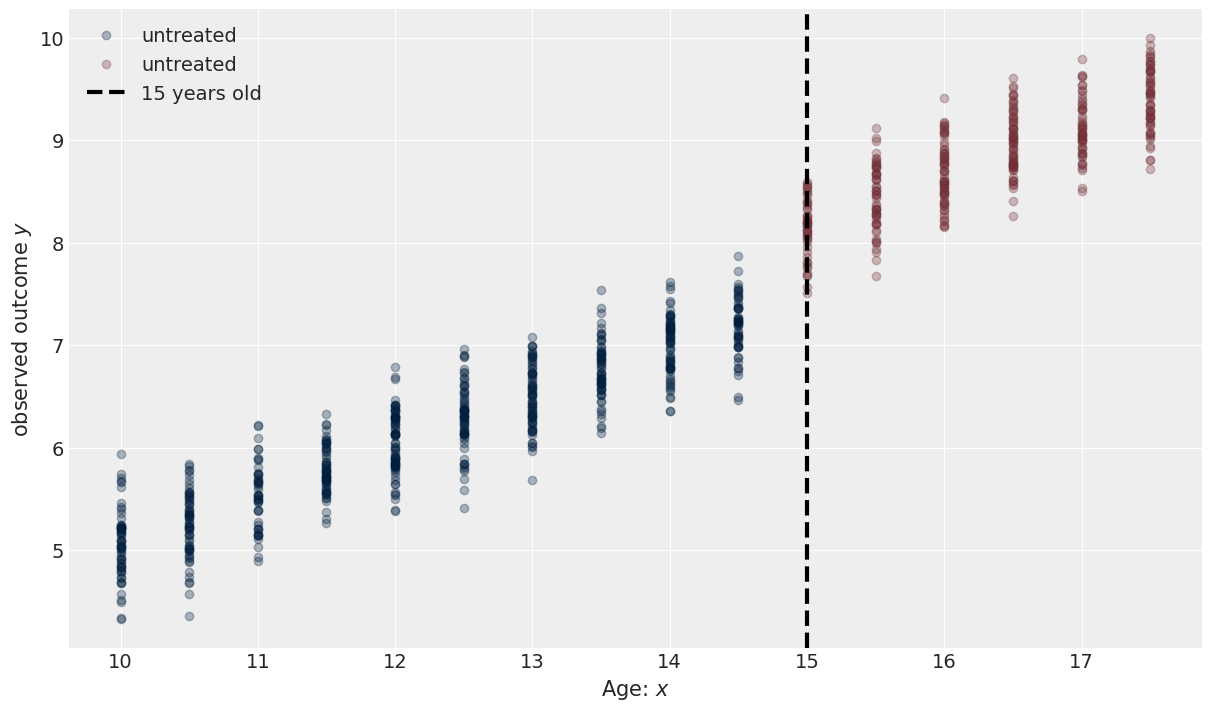

In [31]:
def plot_data(df):
    fig, ax = plt.subplots(figsize=(12, 7))

    # Boolean masks (robust even if treated is int 0/1)
    m0 = df["treated"] == 0
    m1 = df["treated"] == 1

    # Plotting T = 0:
    ax.plot(
        df.loc[m0, "x"],
        df.loc[m0, "y"],
        "o",
        alpha=0.3,
        color="#001F3F",
        label="untreated",
    )
    # Plotting T = 1:
    ax.plot(
        df.loc[m1, "x"],
        df.loc[m1, "y"],
        "o",
        alpha=0.3,
        color="#722F37",
        label="untreated",
    )
    # Threshold Line:
    ax.axvline(x=threshold, color="k", ls="--", lw=3, label="15 years old")
    # Setting Axis Labels:
    ax.set(xlabel=r"Age: $x$", ylabel=r"observed outcome $y$")
    # Adding Legend
    ax.legend()
    return ax


plot_data(df)

__Small Intro__

We have 2 types of the RDD*
- Sharp: No uncertainty in which units in which group <- _This is our case_
- Fuzzy: We are slightly uncertain, some lag in the assignment

### Defining the Bayesian Regression Discountinutiy Model:

$$ \Delta ~ Cauchy(0,1)$$
$$ \sigma ~ HalfNormal(0,1)$$
$$ \mu = x_i + \Delta \times treated_i$$
$$ y_i ~  Normal(\mu, \sigma)$$